### Projeto 3 de Modelagem Matemática - Epidemiologia

###### Aluno: Vitor Mazal Krauss

###### Entrega: 22 de Maio de 2019

###### Objetivos:

Neste trabalho realizamos as duas tarefas a seguir:

1- A partir de dados reais de uma população, consideramos o modelo *SIR* clássico para modelagem da dinâmica da Influenza nesta população e buscamos parâmetros que melhor ajustam o modelo aos dados.

2- Com os parâmetros obtidos em $1$, consideramos um modelo *SIR* com vitalidade e vacinação e buscamos a estratégia ótima de vacinação.

###### Ajuste dos parâmetros

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import integrate
from scipy import integrate, optimize
import scipy
from matplotlib import style
style.use('ggplot')

In [2]:
#Importando os dados
infected = np.array([1,3,7,25,72,222,282,256,233,189,123,70,25,11,4])
TOTAL_POP = 763

Lembramos que no modelo *SIR* clássico, as equações diferenciais que descrevem o número de indivíduos suscetíveis $S$ e infectados $I$ são, respectivamente:

$$ \frac{dS}{dt} = -\beta \frac{I}{N} S $$

$$ \frac{dI}{dt} = \beta \frac{I}{N} S - \gamma I $$

Para determinar os parâmetros que melhor ajustam as EDO's ao dados precisamos, em primeiro lugar, definir o que é "melhor". Neste caso, definiremos uma função de perda quadrática, $$E(\beta, \gamma) = \sum_{i} (I_{s}(t_i \mid \beta, \gamma) - y_i)^2$$ onde $I_{s}(t_i \mid \beta, \gamma)$ é o valor de $I$ no instante $t_i$ obtido pela solução numérica de EDO usando os parâmetros $\beta, \gamma$ e $y_i$ é o valor amostrado para o instante $t_i$. Daí, a estimação se torna um problema de minimização da função de perda nos parâmetros $\beta$ e $\gamma$, o que será feito através do método *scipy.optimize.minimize*. 

In [3]:
class Parametrize_ODE():
    def __init__(self, xdata, ydata, b_zero): # constructing the object
        self.X = xdata  # the xdata, in our case, time dates
        self.y = ydata  # the y data, in our case, the number of infected people
        self.y0 = b_zero  # initial population
    def ode(self, X0, t, beta, gamma): # ode model
        S, I = X0
        N = TOTAL_POP
        dxdt = [- beta*I*S/N, beta*I*S/N - gamma*I]
        return dxdt
    def model(self, X, beta, gamma):  #solution, infected 
            sol = integrate.odeint(self.ode, self.y0, X, args=(beta, gamma,))
            return np.array([sol[i][1] for i in range(len(sol))])
    def model_2(self, X, beta, gamma):  #solution, susceptible
            sol = integrate.odeint(self.ode, self.y0, X, args=(beta, gamma,))
            return np.array([sol[i][0] for i in range(len(sol))])
    def f_resid(self, params):  # the loss/error function
            v = self.y - self.model(self.X, params[0], params[1])
            return np.dot(v, v)
    def optim(self):  #optimize the loss function
        return optimize.minimize(self.f_resid, [0.5, 0.5])

In [4]:
po = Parametrize_ODE(np.array(range(15)), infected, [762,1])
po.optim()

      fun: 4303.51363118725
 hess_inv: array([[ 1.09080600e-07, -1.86887715e-07],
       [-1.86887715e-07,  3.20206090e-07]])
      jac: array([1.1060791 , 1.11682129])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 320
      nit: 15
     njev: 77
   status: 2
  success: False
        x: array([1.66497945, 0.4527559 ])

In [5]:
optimal = po.optim()['x']

Observe que mudamos a escala das unidades do modelo. Geralmente, $\beta, \gamma \in (0,1)$ e $\beta$ representa a probabilidade/taxa de infecção quando um indivíduo suscetível e um infectado interagem, enquanto $\gamma$ é o inverso do tempo de recuperação da doença. Aqui, para haver esta interpretação, basta dividir os parâmetros obtidos por $10$. De fato, houve uma mudança na escala do tempo. Nessa escala, podemos considerar uma unidade de tempo em dias, assim como é utilizado na amostra. 

A seguir, plottamos a solução numérica utilizando os parâmetros ótimos, além dos pontos amostrados. 

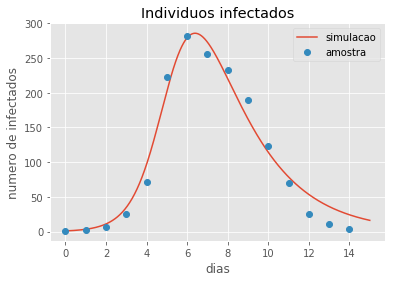

In [6]:
plt.plot(np.linspace(0, 15, 1000), po.model(np.linspace(0,15, 1000), optimal[0], optimal[1]), label="simulacao")
plt.plot(range(15), infected, 'o', label="amostra")
plt.ylabel("numero de infectados")
plt.xlabel("dias")
plt.title("Individuos infectados")
plt.legend()
plt.show()

Plottamos também as três populações juntas.

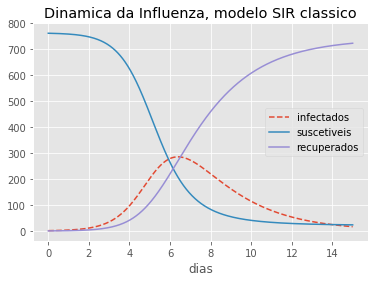

In [7]:
S = po.model_2(np.linspace(0,15, 1000), optimal[0], optimal[1])
I = po.model(np.linspace(0,15, 1000), optimal[0], optimal[1])
R = np.full(1000, 763) - S - I
plt.plot(np.linspace(0, 15, 1000), I, "--", label="infectados")
plt.plot(np.linspace(0, 15, 1000), S,   label="suscetiveis")
plt.plot(np.linspace(0, 15, 1000), R, label="recuperados")
plt.xlabel("dias")
plt.title("Dinamica da Influenza, modelo SIR classico")
plt.legend()
plt.show()

###### Estratégias ótimas de vacinação

Agora consideraremos o modelo *SIR* com taxas de vitalidade e vacinação. Neste modelo, as quantidades $S, I$ e $R$ de indivíduos, respectivamente, suscetíveis, infectados e recuperados são descritas pelas seguintes equações diferenciais: 

$$ \frac{dS}{dt} = \nu N - \beta \frac{I}{N} S - u S - \nu S $$

$$ \frac{dI}{dt} = \beta \frac{I}{N} S - \gamma I - \nu I$$

$$ \frac{dR}{dt} = \gamma I + uS - \nu R $$

Nosso objetivo é encontrar uma estratégia de vacinação ótima, isto é, encontrar uma função $u$(que representa uma taxa de vacinação no tempo) que minimiza o funcional-custo 

$$ J(u) = \int_{0}^{T} \big( A_1 S(t) + A_2 I(t) + \frac{\tau}{2} u^{2}(t) \big) dt $$

com $T=100$, $A_1 = 0.1$, $A_2=1$ e $\tau = 50$.

<u>Detalhes de Implementação</u>: como as funções $u$ que buscaremos tem uma forma específica(de função escada), e que depende apenas de alguns parâmetros reais $a, b, c, t_1$ $t_2$, o problema de encontrar $u$ se torna um problema de minimizar uma função real de várias variáveis. Note que se $u$ fosse livre, nosso desafio seria muito maior.

Além da condição $t_1 < t_2$, também vamos impor algumas restrições nos parâmetros $a, b$ e $c$. Note que apenas com a restrição $0 \leq a,b,c \leq 0.9$ o problema não está muito bem especificado. Fica evidente que $a=b=c=0$, para quaisquer $t_1, t_2$, é um mínimo, pelo menos local, e que vai acabar "atraindo" os nossos métodos de otimização em muitas das vezes. Por isso, adicionamos as seguintes restrições: 

1- $a + b + c \geq 0.05$. Isso garante uma vacinação mínima da população e evita a estratégia $u \equiv 0$

2- $a \neq b, b \neq c, a \neq c$ para evitar estratégias de vacinação constantes(que não dependem de $t_1$ e $t_2$).

In [8]:
class Optimize_U():
    def __init__(self):
        self.T = 10
        self.a_1 = 0.1
        self.a_2 = 1
        self.tau = 50
        self.y0 = [762, 1]
        self.beta = optimal[0]
        self.gamma = optimal[1]
        self.nu = 0.2
    def funcao_u(self, t, a, b, c, t_1, t_2):
        if(0 <= t <= t_1): return a
        elif(t_1 <= t <= t_2): return b
        elif(t_2 <= t <= 100): return c
    def ode(self, X, t, a, b, c, t_1, t_2): # ode model
        u = self.funcao_u(t, a, b, c, t_1, t_2)
        S, I = X
        N = TOTAL_POP
        dxdt = [self.nu*N - self.beta*I*S/N - u*S - self.nu*S, self.beta*I*S/N - self.gamma*I - self.nu*I]
        return dxdt
    def model(self, X, a, b, c, t_1, t_2):  #solution of the model 
            sol = integrate.odeint(self.ode, self.y0, X, args=(a,b,c,t_1,t_2))
            return np.array([sol[i][1] for i in range(len(sol))])
    def model_2(self, X, a,b,c,t_1,t_2):  #solution of the model 
            sol = integrate.odeint(self.ode, self.y0, X, args=(a,b,c,t_1,t_2))
            return np.array([sol[i][0] for i in range(len(sol))])
    def kernel(self, t, a, b, c, t_1, t_2):
        I = self.model(t, a, b, c, t_1, t_2)[0]
        S = self.model_2(t, a, b, c, t_1, t_2)[0]
        return self.a_1*S + self.a_2*I + (self.tau/2)*((self.funcao_u(t, a, b, c, t_1, t_2))**2)
    def functional_cost(self, params):
        return scipy.integrate.quad(self.kernel, 0, self.T, args=(params[0], params[1], params[2], params[3], params[4]))[0]
    def constraint_1(self, x):
        return x[0] + x[1] + x[2] - 0.05
    def constraint_2(self, x):
        if(x[0] != x[1]): return 0
        else: return 1
    def constraint_3(self, x):
        if(x[2] != x[1]): return 0
        else: return 2
    def constraint_5(self, x):
        if(x[0] != x[2]): return 0
        else: return 2
    def constraint_4(self, x):
        if(x[3] < x[4]): return 0
        else: return 1
    def optimize(self, guess, bnds=[(0, 0.9), (0, 0.9), (0, 0.9), (0, 10), (0, 10)]):
        #cons = scipy.optimize.NonlinearConstraint(self.parameters, np.array([0]), np.array([0]))
        cons = ({'type': 'ineq', 'fun': self.constraint_1}, {'type': 'eq', 'fun': self.constraint_2}, {'type': 'eq', 'fun': self.constraint_3}, {'type': 'eq', 'fun': self.constraint_5}, {'type': 'ineq', 'fun': self.constraint_4})
        #cons = ({'type': 'ineq', 'fun': self.constraint_1}, {'type': 'eq', 'fun': self.constraint_2}, {'type': 'eq', 'fun': self.constraint_3}, {'type': 'ineq', 'fun': self.constraint_4})
        return scipy.optimize.minimize(self.functional_cost, guess, bounds=bnds, constraints=cons)

Para evitar um possível viés proveniente da escolha inicial e não ficarmos reclusos a um único mínimo local, vamos calcular a função ótima $u^{*}$ para diversos chutes iniciais e escolher aquela que minimiza o custo.

In [9]:
M = 500
p1 = Optimize_U()
erro = 10**30
index = 0
params = None
for i in range(M):
    b = 10*np.random.beta(8, 3)
    a = b*np.random.beta(4, 8)
    guess = np.append(np.random.uniform(0, 0.9, 3), np.array([a, b]))
    temp = p1.optimize(guess)
    if(temp['fun'] < erro):
        erro = temp['fun']
        params = temp['x']
print("Custo otimo = ", erro)
print("Parametros otimos (a, b, c, t_1, t_2) = ", params)

Custo otimo =  774.063583849927
Parametros otimos (a, b, c, t_1, t_2) =  [0.13665625 0.03271867 0.11689634 1.53977681 6.44826639]


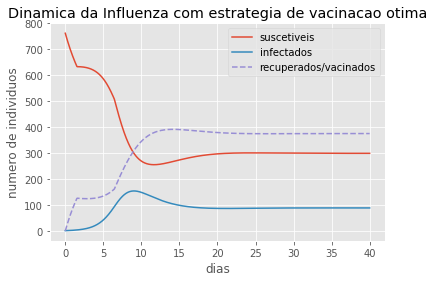

In [10]:
S_1 = p1.model_2(np.linspace(0, 40, 1000), params[0], params[1], params[2], params[3], params[4]) 
I_1 = p1.model(np.linspace(0, 40, 1000), params[0], params[1], params[2], params[3], params[4])
R_1 = np.full(1000, 763) - S_1 - I_1
plt.plot(np.linspace(0, 40, 1000), S_1, label="suscetiveis")
plt.plot(np.linspace(0, 40, 1000), I_1, label="infectados")
plt.plot(np.linspace(0, 40, 1000), R_1, "--", label="recuperados/vacinados")
plt.title("Dinamica da Influenza com estrategia de vacinacao otima")
plt.xlabel("dias")
plt.ylabel("numero de individuos")
plt.legend()
plt.show()